In [94]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import pyDOE
from scipy.stats import pearsonr,spearmanr

rez=100

In [2]:
#whole AB model
def Ab_model(t,c1,c2,r1,r2,hill,IC50):
    Ab_t = c1*np.exp(-r1*t)+c2*np.exp(-r2*t)
    if c1>0:
        E_t = 1/(1+(Ab_t/IC50)**-hill)
    else:
        E_t=0
    return Ab_t,E_t

    
def bnab_ode(x,t,c1,c2,r1,r2,hill,IC50):
    
    dx=np.zeros(4); S=x[0]; L=x[1]; A=x[2]; V=x[3]
    
    Ab_t,E_t = Ab_model(t,c1,c2,r1,r2,hill,IC50)    

    Bt=Bt0*(1-E_t)
    
    dx[0]=aS - dS*S - Bt*S*V
    dx[1]=tau*Bt*S*V + thL*L
    dx[2]=(1-tau)*Bt*S*V - dA*A
    dx[3]=p*A - g*V - Bt*S*V
    
    return dx



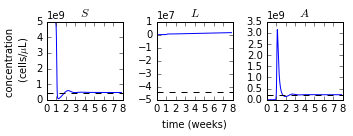

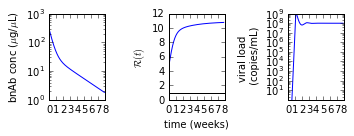

In [150]:

# parameters for viral dynamics model
vol = 1e6       # volume of blood [uL]
aS  = 250*vol   # constant growth rate of suseceptible cells [cells/uL-day]*[uL]
dS  = 0.05      # death rate of suseceptible cells [1/day]
Bt0 = 5e-6/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 1e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate

#equilibriu solutions
l=1-(1+xi/thL)*tau #latency factor
Xeq=np.array([g*dA/Bt0/p/l,tau/thL*(g*dS*dA/Bt0/p/l-aS),aS*l/dA-g*dS/Bt0/p,aS*p*l/g/dA-dS/Bt0])

R0=aS*Bt0*p/g/dS/dA # basic reproductive number

#PK parameters
c1,c2,r1,r2 = 225, 35, 0.348, 0.0538 #low 30 or high 10 dose range

#PD parameters
IC50=200 # IC50 [cells/uL]*[uL]
hill=1       # hill coefficient []

x0=np.array([aS/dS,0,0,1e-3]) #initial model conditions

t=np.linspace(0,55,1e3)

sol = spi.odeint(bnab_ode, x0, t, args=(c1,c2,r1,r2,hill,IC50))

plt.figure(figsize=(5,2),dpi=rez)
titz=['$S$','$L$','$A$']
for i in range(3):
    plt.subplot(131+i)
    plt.plot(t/7,sol[:,i])
    plt.axhline(Xeq[i],ls='--',color='k')
    plt.xticks(range(9))
    plt.title(titz[i])
    
    if i==1:
        plt.xlabel('time (weeks)')
    if i==0:
        plt.ylabel('concentration \n (cells/$\mu$L)')
plt.tight_layout()

plt.figure(figsize=(5,2),dpi=rez)
Ab_t,E_t  = Ab_model(t,c1,c2,r1,r2,hill,IC50)

plt.subplot(131)
plt.semilogy(t/7,Ab_t)
plt.xticks(range(9))
plt.ylabel('bnAb conc ($\mu$g/$\mu$L)')

plt.subplot(132)
plt.plot(t/7,(1-E_t)*R0)
plt.axhline(1,color='k')
plt.xticks(range(9))
plt.ylabel(r'$\mathcal{R}(t)$')
plt.xlabel('time (weeks)')

plt.subplot(133)
plt.semilogy(t/7,sol[:,3]/1e3)
plt.ylim([1,1e9])
plt.yticks(np.logspace(1,9,9))
plt.xticks(range(9))
plt.ylabel('viral load \n (copies/mL)')

plt.tight_layout()


In [134]:
R0

10.869565217391303

In [135]:
#updating the rates of events
num_rates=9; num_states=4; r=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

def update_rates(X,ti,c1,c2,r1,r2,hill,IC50):
        
    Ab_t,E_t = Ab_model(ti%56,c1,c2,r1,r2,hill,IC50)    #refreshes every 8 weeks

    Bt=Bt0*(1-E_t) #ab dependent infectivity
    
    S=X[0]; L=X[1]; A=X[2]; V=X[3]
    
    kp=1; pr=np.random.gamma(kp,p)
    #pr=np.random.poisson(p)
    
    r[0] = aS;             T[0][:]=[1,0,0,0];  #constant production 
    r[1] = dS*S;           T[1][:]=[-1,0,0,0]  #density dependent susceptible death
    r[2] = tau*Bt*S*V;     T[2][:]=[-1,1,0,-1] #latent infection
    r[3] = (1-tau)*Bt*S*V; T[3][:]=[-1,0,1,-1] #active infection
    r[4] = dA*A;           T[4][:]=[0,0,-1,pr]  #infected cell burst
    r[5] = g*V;            T[5][:]=[0,0,0,-1]  #density dependent viral clearance
    r[6] = xi*L;           T[6][:]=[0,-1,1,0]  #latent to active
    r[7] = dL*L;           T[7][:]=[0,-1,0,0]  #latent death
    r[8] = aL*L;           T[8][:]=[0,1,0,0]   #homeostatic division proliferation
    
    return r,T #updating the rates of events


#function that solves stochastically using tau-leap method
def bnabs_tauleap(t,fp_time,c1,c2,r1,r2,hill,IC50):

    dt=t[1]; x=np.array([aS/dS,0,0,0]); y=[] #initialize
    fp_flag='no'
    for ti in t:
        
        y.append(x) #the list of states

        r,T = update_rates(x,ti,c1,c2,r1,r2,hill,IC50) #make new rate vector
        
        E = np.random.poisson(r*dt) #calculate events
        
        dx = np.sum(np.matrix.transpose(T)*E,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti>fp_time and fp_flag=='no':
            x[2] = x[2] + 1
            fp_flag=='yes'
 
        x[x<1]=0 #make sure no negative numbers or fractions
        
    return np.array(y)

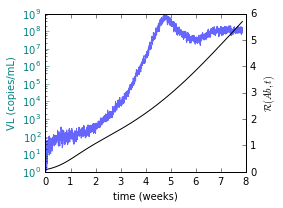

In [138]:
#do a single simulation without antibodies

c1,c2,r1,r2 = 225,35,0.348,0.0538 #low 30 or high 10 dose range
IC50=2
hill=1

num_sims=1; 
t=np.linspace(0,55,1e4)

fp_time=0

Ab_t,E_t = Ab_model(t%56,c1,c2,r1,r2,hill,IC50)    #refreshes every 8 weeks

col1='teal'
col2='black'

fig, ax1 = plt.subplots(figsize=(4,3),dpi=rez)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,fp_time,c1,c2,r1,r2,hill,IC50)
    ax1.semilogy(t/7,tlp_sol[:,3]/1e3,alpha=0.6)
    ax1.set_ylabel('VL (copies/mL)',color=col1)
    ax1.set_xlabel('time (weeks)')
    ax1.tick_params('y', colors=col1)
    
    ax2 = ax1.twinx()
    ax2.plot(t/7, R0*(1-E_t), color=col2)
    ax2.set_ylabel('$\mathcal{R}(Ab,t)$', color=col2)
    ax2.tick_params('y', colors=col2)

fig.tight_layout()

fig.savefig('figures/examples.pdf')  # No warning now


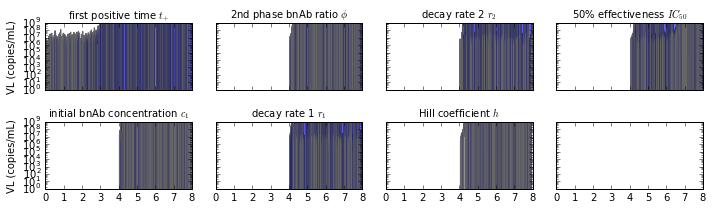

In [146]:

################################################################################
#local sensitivity analysis function

#variables to check sensitivity
variables = ['first positive time ' + r'$t_{+}$',
             'initial bnAb concentration ' + r'$c_1$', 
             '2nd phase bnAb ratio ' + r'$\phi$',
             'decay rate 1 ' + r'$r_1$',
             'decay rate 2 ' + r'$r_2$',
             'Hill coefficient ' + r'$h$',
             '50% effectiveness ' + r'$IC_{50}$']

#from data_analysis fitting:
#[86  2.5 0.15 0.007] +/- [ 32.7 32.6 0.12 0.29 ]
#[240 2.9 0.086 -0.011] +/- [ 112 116 0.081 0.71]

#ranges of variables for LHS, mostly made up to consider all options
rangez= np.array([
            [0,56],   #t+
            [0,600],  #c1
            [0,200],  #c2
            [0,0.3],  #r1
            [0,0.7],  #r2
            [1,5],  #h
            [0.2,20]])  #IC50
                            
t=np.linspace(0,56,1e3) #8 week time series in days

fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,3),dpi=rez)
#looping over the number of variables to check sensitivity
for i in range(len(variables)):

    #set values at initials, mean??
    lo=np.mean(rangez,1); hi=np.mean(rangez,1);      

    #change the i-th parameter
    lo[i]=rangez[i][0]; hi[i]=rangez[i][1]
    
    #evaluate model
    fp_time,c1,c2,r1,r2,hill,IC50=lo
    lo_sol = bnabs_tauleap(t,fp_time,c1,c2,r1,r2,hill,IC50)
    
    fp_time,c1,c2,r1,r2,hill,IC50=hi
    hi_sol = bnabs_tauleap(t,fp_time,c1,c2,r1,r2,hill,IC50)

    ax=axarr[i%2][int(i/2.)]
    ax.fill_between(t/7,lo_sol[:,3]*1e3,hi_sol[:,3]*1e3,alpha=0.6)
    #ax.semilogy(t/365,med[5],t,HI_sol[5],alpha=0.1,color='chocolate')
    #ax.fill_between(t/365,LO_sol[5],HI_sol[5],alpha=0.5,color='tomato') #observed
    #ax.fill_between(t/365,LO_sol[6],HI_sol[6],alpha=0.5,color='limegreen') #de novo

    #ax.set_ylim([0.1,100])
    ax.set_title(variables[i],fontsize=10)# + str(rangez[i][0]) + r'$\to$' +str(rangez[i][1]),fontsize=10)
    #ax.set_xticks(range(4))

axarr[0][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[1][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[0][0].set_ylim([1,1e9])
axarr[0][0].set_yscale('log')

plt.tight_layout()
plt.savefig('figures/sensitivity_local.pdf')




In [147]:
################################################################################
#global sensitivity analysis function

sampz=1000

lhs_samples = pyDOE.lhs( int(len(variables)), samples=sampz, criterion='center')

t=np.linspace(0,56,1e3) #8 week time series in days

var_vals=np.zeros(len(variables))
var_vals_list=np.zeros([len(variables),sampz])

peak_list=np.zeros(sampz)
tpeak_list=np.zeros(sampz)
sp_list=np.zeros(sampz)

if sampz<101:
    fig, ax = plt.subplots(1,2,figsize=(4,3),dpi=rez)

#looping over the number of LHS samples
for i in range(sampz):

    #I3_0    = 10**(np.log10(rangez[0][0]) + lhs_samples[i][0]*(np.log10(rangez[0][1])-np.log10(rangez[0][0])))

    #make the variable values using the LHS sampling
    for j in range(len(variables)):
        var_vals[j]=rangez[j][0] + lhs_samples[i][j]*(rangez[j][1]-rangez[j][0])

    var_vals_list[:,i]=var_vals
    
    fp_time,c1,c2,r1,r2,hill,IC50=var_vals
    sol = bnabs_tauleap(t,fp_time,c1,c2,r1,r2,hill,IC50) #solve the model for this LHS list

    fp_index=np.argwhere(fp_time<t)[0][0]
    peak=np.max(sol[fp_index:,3])
    tpeak=t[np.argwhere(sol[:,3]==peak)[0][0]]    

    peak_list[i]=peak
    tpeak_list[i]=tpeak
    
    if (fp_index+250)<len(t):
        sp=np.mean(sol[fp_index+250:,3]) #2 weeks later
    else:
        sp=0
        
    sp_list[i]=sp

    if sampz<101:
        #make plots showing variation              
        ax[0].semilogy(t/7,sol[:,3]*1e3,alpha=0.3)
        ax[0].set_ylabel('VL (copies/mL)')
        ax[0].set_xlabel('time (weeks)')

        Ab_t,E_t = Ab_model(t%56,c1,c2,r1,r2,hill,IC50)    #refreshes every 8 weeks
        ax[1].plot(t/7, R0*(1-E_t),alpha=0.3)
        ax[1].set_ylabel('$\mathcal{R}(Ab,t)$')
        ax[0].set_xlabel('time (weeks)')

if sampz<101:
    plt.tight_layout()

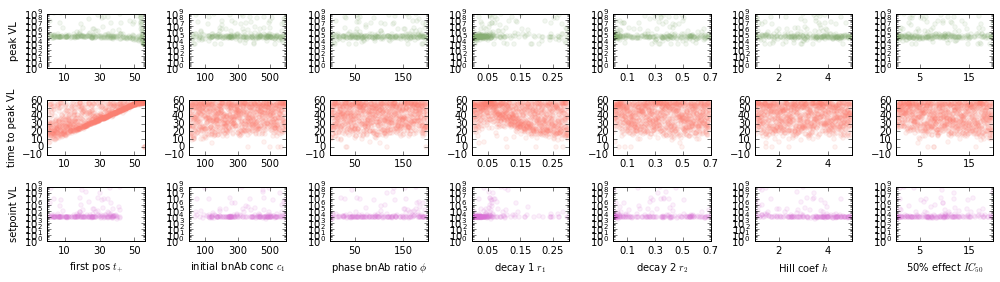

In [148]:
vars_short = ['first pos ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$c_1$', 
             'phase bnAb ratio ' + r'$\phi$',
             'decay 1 ' + r'$r_1$',
             'decay 2 ' + r'$r_2$',
             'Hill coef ' + r'$h$',
             '50% effect ' + r'$IC_{50}$']

corr_peak=np.zeros([len(variables),2])
corr_tpeak=np.zeros([len(variables),2])
corr_sp=np.zeros([len(variables),2])

fig,axarr = plt.subplots(3,7,figsize=(14,4),dpi=rez)
for i in range(len(variables)):

    #compute correlations (ranked via spearman)
    corr_peak[i]=spearmanr(var_vals_list[i,:],peak_list)
    corr_tpeak[i]=spearmanr(var_vals_list[i,:],tpeak_list)
    corr_sp[i]=spearmanr(var_vals_list[i,:],sp_list)

    #because of artificial stopping time for sp calculation
    if i==0:
        corr_sp[i]=spearmanr(var_vals_list[i,:-250],sp_list[:-250])
        
    ax=axarr[0][i]
    ax.scatter(var_vals_list[i,:],peak_list,alpha=0.1,color='sage')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yscale('log')
    ax.set_ylim([1,1e9])
    ax.set_xlim(rangez[i])

    ax=axarr[1][i]
    ax.scatter(var_vals_list[i,:],tpeak_list,alpha=0.1,color='salmon')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xlim(rangez[i])

    ax=axarr[2][i]
    ax.scatter(var_vals_list[i,:],sp_list,alpha=0.1,color='orchid')
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yscale('log')
    ax.set_ylim([1,1e9])
    ax.set_xlabel(vars_short[i],fontsize=10)
    ax.set_xlim(rangez[i])

axarr[0][0].set_ylabel('peak VL',fontsize=10)
axarr[1][0].set_ylabel('time to peak VL',fontsize=10)
axarr[2][0].set_ylabel('setpoint VL',fontsize=10)

plt.tight_layout()
plt.savefig('figures/sensitivity_global_scatters.pdf')


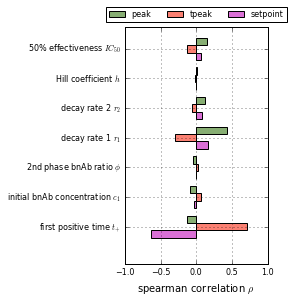

In [149]:

#correlation coefficient bar plots
plt.figure(figsize=(4,4),dpi=rez)
bspace=np.arange(0,len(variables)*2,2)

#sort the variable names for y axis labels
#indz=cum_corrs[:,0].argsort()
#sorted_vars=[]
#for kk in range(len(variables)):
#    sorted_vars.append(variables[indz[kk]])

plt.barh(bspace+0.75,corr_peak[:,0],0.5,color='sage')
plt.barh(bspace+0.25,corr_tpeak[:,0],0.5,color='salmon')
plt.barh(bspace-0.25,corr_sp[:,0],0.5,color='orchid')

plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(np.linspace(-1,1,5))

plt.xlabel('spearman correlation '+ r'$\rho$',fontsize=10)
plt.grid('on')
plt.yticks(bspace+0.5,variables,fontsize=8)
plt.legend(['peak','tpeak','setpoint'],fontsize=8,loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)

plt.tight_layout()
plt.savefig('figures/sensitivity_correlation_bars.pdf')
    
